# DATA PROJECT

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# import dst data loader
import pydst
Dst = pydst.Dst(lang='en') 


pd.set_option('display.max_rows', None)   # show all rows
pd.set_option('display.max_columns', None)   # show all columns


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [2]:
# Data for industrial robots on industry, year for Denmark
filename = 'ifr_dk.csv'
df_ifr = pd.read_csv(filename, delimiter=';')

# Drop obs that are not relevant (data not valid before 2004)
drop = [str(year) for year in range(1993,2004)]
df_ifr.drop(drop, axis=1, inplace=True)
df_ifr = df_ifr.iloc[1:20, :]

# Renaming columns
col_dict = {}
for i in range(2004, 2016+1): 
    col_dict[str(i)] = f'year{i}' 
    df_ifr[str(i)] = df_ifr[str(i)].apply(str)
col_dict['DK'] = f'BRANCHE_IFR' 

# Omdøber kolonner
df_ifr.rename(columns=col_dict, inplace=True)

# Transponerer med melt
df_ifr_long = pd.melt(df_ifr, id_vars=['BRANCHE_IFR'], var_name='year', value_name='value')
df_ifr_long['year'] = df_ifr_long['year'].str.replace('year', '').astype(int)

df_ifr_long.head(20)


,BRANCHE_IFR,year,value
0,"A-B-Agriculture, forestry, fishing",2004,59
1,C-Mining and quarrying,2004,46
2,10-12-Food and beverages,2004,145
3,13-15-Textiles,2004,95
4,16-Wood and furniture,2004,262
5,17-18-Paper,2004,14
6,19-22-Plastic and chemical products,2004,295
7,"23-Glass, ceramics, stone, mineral products (n...",2004,0
8,24-Basic metals,2004,70
9,25-Metal products (non-automotive),2004,928


In [3]:
# Inspicerer indhold
nabb69_vars = Dst.get_variables(table_id='NABB69')
nabb69_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'SOCIO':['EMPM_DC'],'BRANCHE':['*'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer data
nabb69 = Dst.get_data(table_id = 'NABB69', variables=variables)
nabb69.sort_values(by=['SOCIO', 'TID', 'BRANCHE'], inplace=True)

# Ordner og aggregerer industri-koder: Klar til merge med ifr
# Dictionary for oversættelse af industri-koder
industry = nabb69.BRANCHE
dict_nabb69    = {x[:5]: x[6:] for x in industry}
dict_crosswalk = {'01000':'A-B-Agriculture, forestry, fishing',
                  '02000':'A-B-Agriculture, forestry, fishing',
                  '03000':'A-B-Agriculture, forestry, fishing',
                  '06090':'C-Mining and quarrying',
                  '10120': '10-12-Food and beverages',
                  '13150':'13-15-Textiles',
                  '16000': '16-Wood and furniture',
                  '17000':'17-18-Paper',
                  '18000':'17-18-Paper',
                  '19000':'19-22-Plastic and chemical products',
                  '20000':'19-22-Plastic and chemical products',
                  '21000':'19-22-Plastic and chemical products',
                  '22000':'19-22-Plastic and chemical products',
                  '23000':'23-Glass, ceramics, stone, mineral products (n...',
                  '24000':'24-Basic metals',
                  '25000':'25-Metal products (non-automotive)',
                  '28000':'28-Industrial machinery',
                  '26000':'26-27-Electrical/electronics',
                  '27000':'26-27-Electrical/electronics',
                  '29000':'29-Automotive',
                  '30000':'30-Other vehicles',
                  '31320':'91-All other manufacturing branches',
                  '33000':'91-All other manufacturing branches',
                  '35000':'E-Electricity, gas, water supply',
                  '36000':'E-Electricity, gas, water supply',
                  '37390':'E-Electricity, gas, water supply',
                  '41430':'Construction',
                  '72002':'P-Education/research/development',
                  '85202':'P-Education/research/development'}

# Opdaterer dictionary så alle andre kategorier får '90'.
dict_crosswalk.update({
    str(key): '90-All other non-manufacturing branches'
    for key in range(0, 100000)
    if str(key) not in dict_crosswalk
})

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
nabb69['BRANCHE_K'] = nabb69['BRANCHE'].str[:5]
nabb69['BRANCHE_IFR'] = nabb69['BRANCHE_K'].map(dict_crosswalk)

# Aggregerer på IFR-industrier og tid
nabb69['emp_ifr'] = nabb69.groupby(['BRANCHE_IFR', 'TID'])['INDHOLD'].transform(sum)

nabb69 = nabb69[nabb69['BRANCHE_K'].str.isnumeric()]

# Beholder kun subset: relevante obs og variable
nabb69 = nabb69.loc[:, ['TID', 'BRANCHE_IFR', 'emp_ifr']]
nabb69 = nabb69.drop_duplicates(subset=['BRANCHE_IFR', 'TID'])
nabb69.rename(columns={'TID': 'year'}, inplace=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


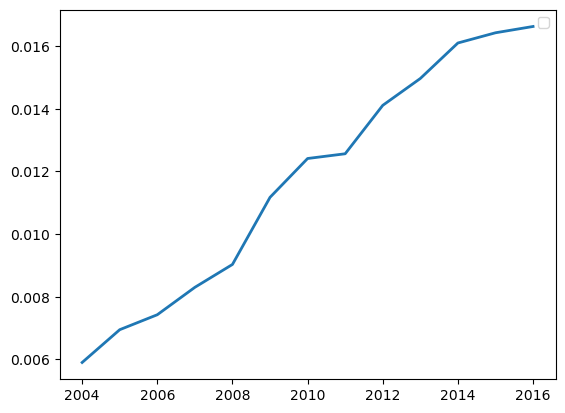

In [23]:
# Merger datasæt på IFR og year
ifr_nabb69 = pd.merge(df_ifr_long, nabb69, on=['BRANCHE_IFR', 'year'], how='left')
ifr_nabb69.value = ifr_nabb69.value.astype(float)
ifr_nabb69.head(10)

# Udregner robost pr. ths. worker (relativt mål for robot-intensiteten i en industri)
ifr_nabb69['rob_pr_ths'] = ifr_nabb69.value/ifr_nabb69.emp_ifr
ifr_nabb69 = ifr_nabb69.dropna()

# Udregner mean pr. år på tværs af industrier
rob_pr_ths_mean      = ifr_nabb69.groupby(['year'])['rob_pr_ths'].mean()
ifr_nabb69           = pd.merge(ifr_nabb69, rob_pr_ths_mean, on=['year'], how='left')

# Renamer kolonner
ifr_nabb69.rename(columns={'rob_pr_ths_x': 'rob_pr_ths',
                           'rob_pr_ths_y': 'rob_pr_ths_y_mean'}, inplace=True)

#Create line plot for aggregate development in robots across industries
plt.plot(ifr_nabb69.year, ifr_nabb69.rob_pr_ths_y_mean, label=None, marker=None, linestyle='-', linewidth=2)
x_pos = ifr_nabb69.year.iloc[-1] + 0.2
y_pos = ifr_nabb69.rob_pr_ths_y_mean.iloc[-1]
    

#Create line plot for each industry
# for industry, data in ifr_nabb69.groupby('BRANCHE_IFR'):
#     plt.plot(data.year, data.rob_pr_ths, label=None, marker=None, linestyle='-', linewidth=2)
#     x_pos = data.year.iloc[-1] + 0.2
#     y_pos = data.rob_pr_ths.iloc[-1]
#     plt.annotate(industry, xy=(x_pos, y_pos), ha='left', va='center')

plt.legend()
plt.show()

def plot_rob_pr_ths():
    # a. create the figure
    fig = plt.figure(figsize=(12,6))


    # b. plot for alpha
    ax = fig.add_subplot(1,2,1)

    ax.plot(alphas,ratio_alpha)

    ax.set_title(f'Household hours ratio, HF/HM')
    ax.set_xlabel(f'alpha')
    ax.set_ylabel(f'HF/HM')

    # c. plot for sigma
    ax = fig.add_subplot(1,2,2,)

    ax.plot(sigmas,ratio_sigma)

    ax.set_title(f'Household hours ratio, HF/HM')
    ax.set_xlabel(f'sigma')
    ax.set_ylabel(f'HF/HM')


plot_alpha_sigma()  
#print(HM_vec,HF_vec)



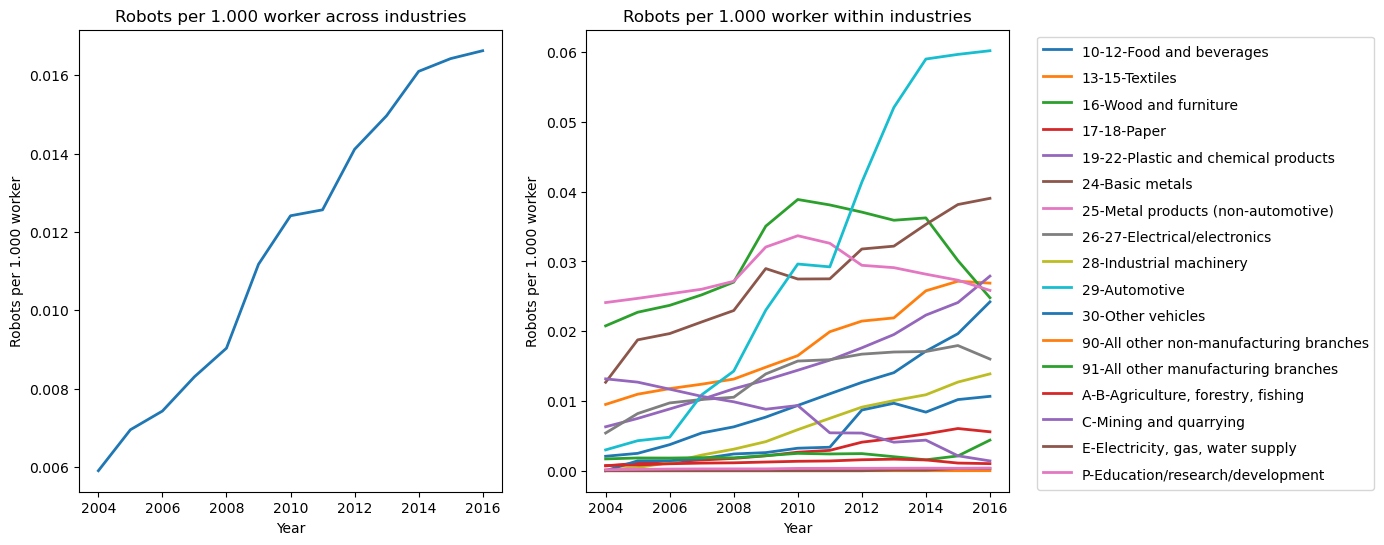

In [43]:
def plot_rob_pr_ths():
    plot = plt.figure(figsize=(12,6))

    # a. create line plot for aggregate development in robots across industries
    ax = plot.add_subplot(1,2,1)

    ax.plot(ifr_nabb69.year, ifr_nabb69.rob_pr_ths_y_mean, label=None, marker=None, linestyle='-', linewidth=2)
    #x_pos = ifr_nabb69.year.iloc[-1] + 0.2
    #y_pos = ifr_nabb69.rob_pr_ths_y_mean.iloc[-1]
    
    ax.set_title(f'Robots per 1.000 worker across industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')

    # b. plot for each industry
    ax = plot.add_subplot(1,2,2)

    for industry, data in ifr_nabb69.groupby('BRANCHE_IFR'):
        #ax.plot(data.year, data.rob_pr_ths, label=None, marker=None, linestyle='-', linewidth=2)
        ax.plot(data.year, data.rob_pr_ths, label=industry, marker=None, linestyle='-', linewidth=2)
        #x_pos = data.year.iloc[-1] + 0.2
        #y_pos = data.rob_pr_ths.iloc[-1]
        #ax.annotate(industry, xy=(x_pos, y_pos), ha='left', va='center')

    ax.set_title(f'Robots per 1.000 worker within industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), handleheight=1.78)


plot_rob_pr_ths()  

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [5]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [6]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

NameError: name 'venn2' is not defined

<Figure size 1500x700 with 0 Axes>

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.